# Tutorial: Two dimensional Wave problem with hard constraint

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mathLab/PINA/blob/master/tutorials/tutorial3/tutorial.ipynb)

In this tutorial we present how to solve the wave equation using hard constraint PINNs. For doing so we will build a costum `torch` model and pass it to the `PINN` solver.

First of all, some useful imports.

In [1]:
## routine needed to run the notebook on Google Colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
if IN_COLAB:
  !pip install "pina-mathlab"
  
import torch
import matplotlib.pyplot as plt
import warnings

from pina import Condition, LabelTensor
from pina.problem import SpatialProblem, TimeDependentProblem
from pina.operator import laplacian, grad
from pina.domain import CartesianDomain
from pina.solver import PINN
from pina.trainer import Trainer
from pina.equation import Equation, FixedValue

from lightning.pytorch.loggers import TensorBoardLogger

warnings.filterwarnings('ignore')

## The problem definition 

The problem is written in the following form:

\begin{equation}
\begin{cases}
\Delta u(x,y,t) = \frac{\partial^2}{\partial t^2} u(x,y,t) \quad \text{in } D, \\\\
u(x, y, t=0) = \sin(\pi x)\sin(\pi y), \\\\
u(x, y, t) = 0 \quad \text{on } \Gamma_1 \cup \Gamma_2 \cup \Gamma_3 \cup \Gamma_4,
\end{cases}
\end{equation}

where $D$ is a squared domain $[0,1]^2$, and $\Gamma_i$, with $i=1,...,4$, are the boundaries of the square, and the velocity in the standard wave equation is fixed to one.

Now, the wave problem is written in PINA code as a class, inheriting from `SpatialProblem` and `TimeDependentProblem` since we deal with spatial, and time dependent variables. The equations are written as `conditions` that should be satisfied in the corresponding domains. `truth_solution` is the exact solution which will be compared with the predicted one.

In [2]:
class Wave(TimeDependentProblem, SpatialProblem):
    output_variables = ["u"]
    spatial_domain = CartesianDomain({"x": [0, 1], "y": [0, 1]})
    temporal_domain = CartesianDomain({"t": [0, 1]})

    def wave_equation(input_, output_):
        u_t = grad(output_, input_, components=["u"], d=["t"])
        u_tt = grad(u_t, input_, components=["dudt"], d=["t"])
        nabla_u = laplacian(output_, input_, components=["u"], d=["x", "y"])
        return nabla_u - u_tt

    def initial_condition(input_, output_):
        u_expected = torch.sin(torch.pi * input_.extract(["x"])) * torch.sin(
            torch.pi * input_.extract(["y"])
        )
        return output_.extract(["u"]) - u_expected

    conditions = {
        "bound_cond1": Condition(
            domain=CartesianDomain({"x": [0, 1], "y": 1, "t": [0, 1]}),
            equation=FixedValue(0.0),
        ),
        "bound_cond2": Condition(
            domain=CartesianDomain({"x": [0, 1], "y": 0, "t": [0, 1]}),
            equation=FixedValue(0.0),
        ),
        "bound_cond3": Condition(
            domain=CartesianDomain({"x": 1, "y": [0, 1], "t": [0, 1]}),
            equation=FixedValue(0.0),
        ),
        "bound_cond4": Condition(
            domain=CartesianDomain({"x": 0, "y": [0, 1], "t": [0, 1]}),
            equation=FixedValue(0.0),
        ),
        "time_cond": Condition(
            domain=CartesianDomain({"x": [0, 1], "y": [0, 1], "t": 0}),
            equation=Equation(initial_condition),
        ),
        "phys_cond": Condition(
            domain=CartesianDomain({"x": [0, 1], "y": [0, 1], "t": [0, 1]}),
            equation=Equation(wave_equation),
        ),
    }

    def truth_solution(self, pts):
        f = (
            torch.sin(torch.pi * pts.extract(["x"]))
            * torch.sin(torch.pi * pts.extract(["y"]))
            * torch.cos(
                torch.sqrt(torch.tensor(2.0)) * torch.pi * pts.extract(["t"])
            )
        )
        return LabelTensor(f, self.output_variables)


# define problem
problem = Wave()

## Hard Constraint Model

After the problem, a **torch** model is needed to solve the PINN. Usually, many models are already implemented in **PINA**, but the user has the possibility to build his/her own model in `torch`. The hard constraint we impose is on the boundary of the spatial domain. Specifically, our solution is written as:

$$ u_{\rm{pinn}} = xy(1-x)(1-y)\cdot NN(x, y, t), $$

where $NN$ is the neural net output. This neural network takes as input the coordinates (in this case $x$, $y$ and $t$) and provides the unknown field $u$. By construction, it is zero on the boundaries. The residuals of the equations are evaluated at several sampling points (which the user can manipulate using the method `discretise_domain`) and the loss minimized by the neural network is the sum of the residuals.

In [3]:
class HardMLP(torch.nn.Module):

    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.layers = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 40),
            torch.nn.ReLU(),
            torch.nn.Linear(40, 40),
            torch.nn.ReLU(),
            torch.nn.Linear(40, output_dim),
        )

    # here in the foward we implement the hard constraints
    def forward(self, x):
        hard = (
            x.extract(["x"])
            * (1 - x.extract(["x"]))
            * x.extract(["y"])
            * (1 - x.extract(["y"]))
        )
        return hard * self.layers(x)

## Train and Inference

In this tutorial, the neural network is trained for 1000 epochs with a learning rate of 0.001 (default in `PINN`). As always, we will log using `Tensorboard`.

In [4]:
# generate the data
problem.discretise_domain(
    1000,
    "random",
    domains=[
        "phys_cond",
        "time_cond",
        "bound_cond1",
        "bound_cond2",
        "bound_cond3",
        "bound_cond4",
    ],
)

# define model
model = HardMLP(len(problem.input_variables), len(problem.output_variables))

# crete the solver
pinn = PINN(problem=problem, model=model)

# create trainer and train
trainer = Trainer(
    solver=pinn,
    max_epochs=1000,
    accelerator="cpu",
    enable_model_summary=False,
    train_size=1.0,
    val_size=0.0,
    test_size=0.0,
    logger=TensorBoardLogger("tutorial_logs")
)
trainer.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 24.31it/s, v_num=3, bound_cond1_loss=0.000, bound_cond2_loss=0.000, bound_cond3_loss=0.000, bound_cond4_loss=0.000, time_cond_loss=0.0328, phys_cond_loss=0.0175, train_loss=0.0504]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 20.77it/s, v_num=3, bound_cond1_loss=0.000, bound_cond2_loss=0.000, bound_cond3_loss=0.000, bound_cond4_loss=0.000, time_cond_loss=0.0328, phys_cond_loss=0.0175, train_loss=0.0504]


Let's now plot the logging to see how the losses vary during training. For this, we will use `TensorBoard`.

In [ ]:
print('\nTo load TensorBoard run load_ext tensorboard on your terminal')
print("To visualize the loss you can run tensorboard --logdir 'tutorial_logs' on your terminal\n")

To load TensorBoard run load_ext tensorboard on your terminal
To visualize the loss you can run tensorboard --logdir 'tutorial_logs' on your terminal


Notice that the loss on the boundaries of the spatial domain is exactly zero, as expected! After the training is completed one can now plot some results using the `matplotlib`. We plot the predicted output on the left side, the true solution at the center and the difference on the right side using the `plot_solution` function.

In [6]:
@torch.no_grad()
def plot_solution(solver, time):
    # get the problem
    problem = solver.problem
    # get spatial points
    spatial_samples = problem.spatial_domain.sample(30, "grid")
    # get temporal value
    time = LabelTensor(torch.tensor([[time]]), "t")
    # cross data
    points = spatial_samples.append(time, mode="cross")
    # compute pinn solution, true solution and absolute difference
    data = {
        "PINN solution": solver(points),
        "True solution": problem.truth_solution(points),
        "Absolute Difference": torch.abs(
            solver(points) - problem.truth_solution(points)
        )
    }
    # plot the solution
    plt.suptitle(f'Solution for time {time.item()}')
    for idx, (title, field) in enumerate(data.items()):
        plt.subplot(1, 3, idx + 1)
        plt.title(title)
        plt.tricontourf(  # convert to torch tensor + flatten
            points.extract("x").tensor.flatten(),
            points.extract("y").tensor.flatten(),
            field.tensor.flatten(),
        )
        plt.colorbar(), plt.tight_layout()

Let's take a look at the results at different times, for example `0.0`, `0.5` and `1.0`:

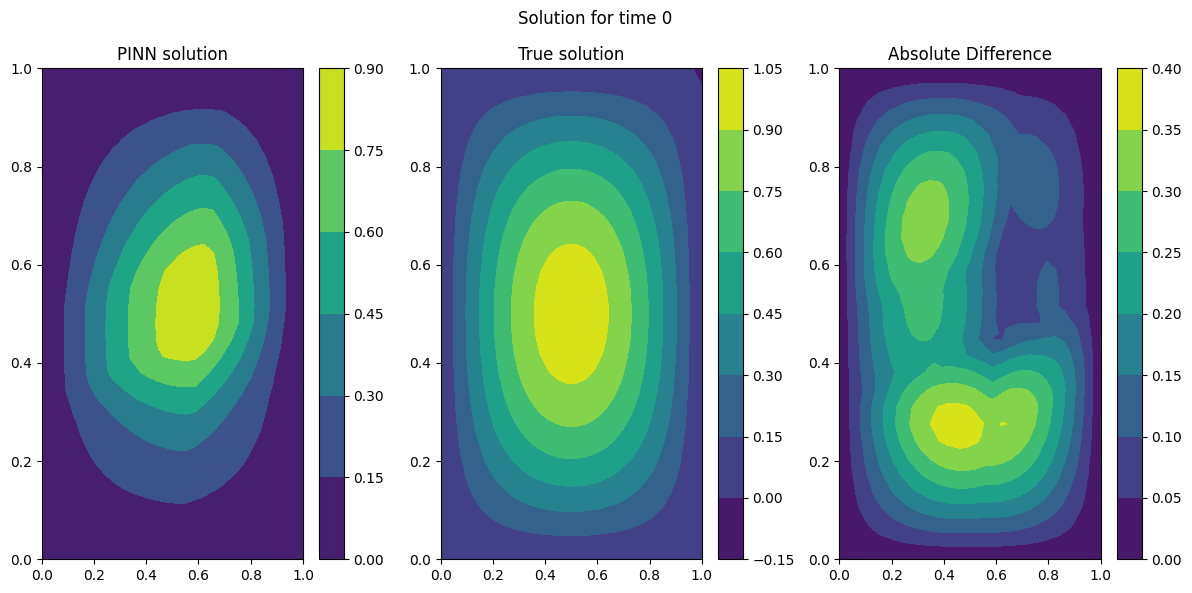

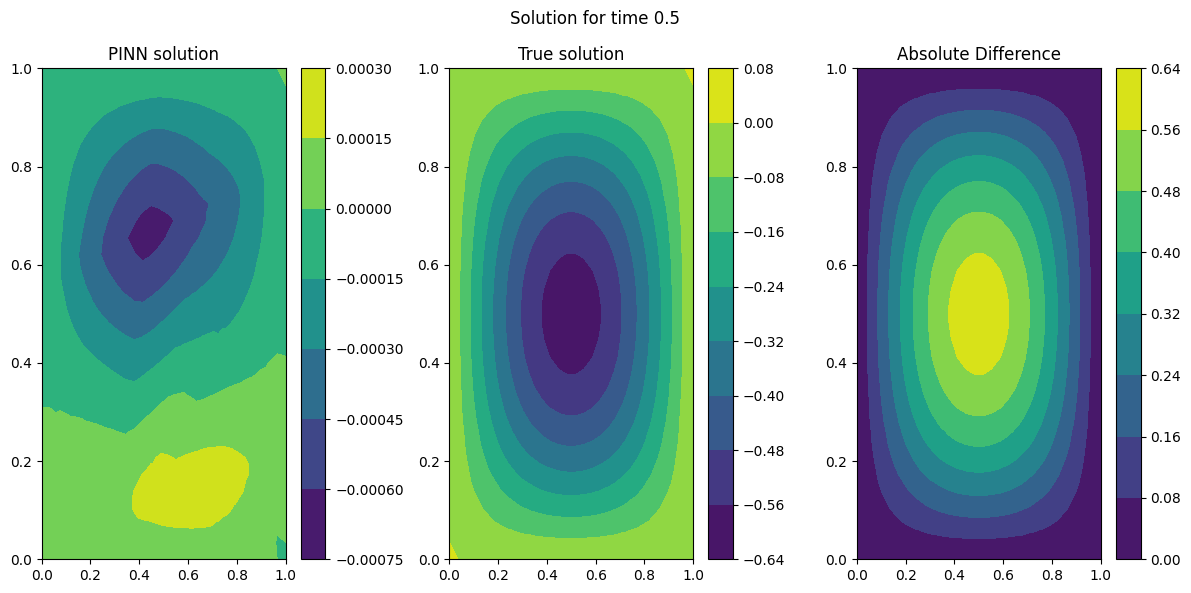

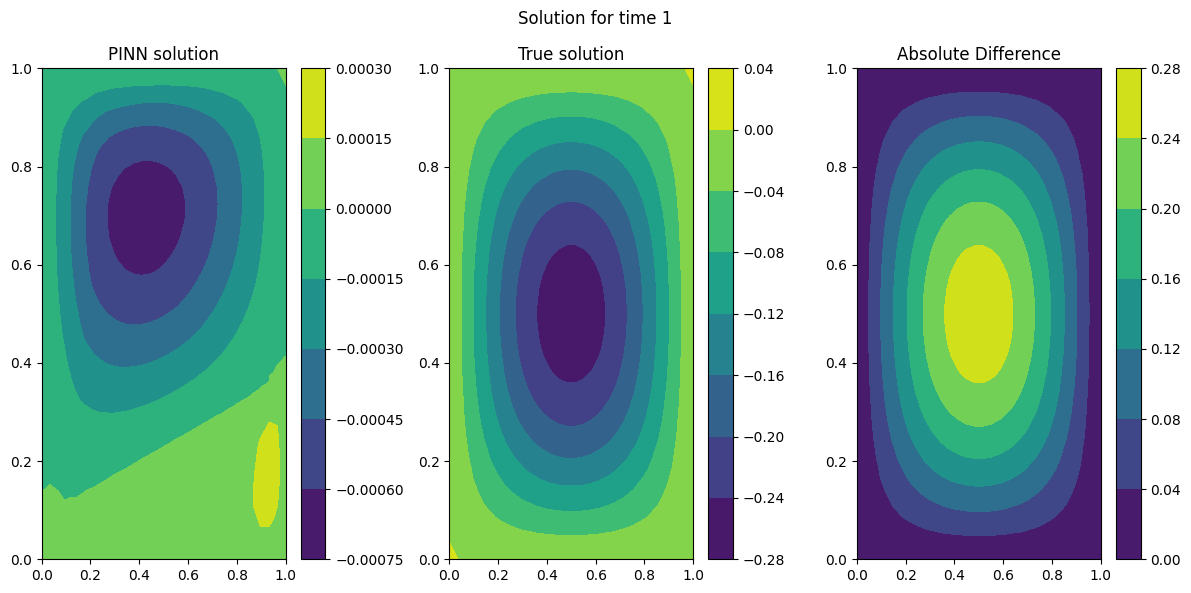

In [7]:
plt.figure(figsize=(12, 6))
plot_solution(solver=pinn, time=0)

plt.figure(figsize=(12, 6))
plot_solution(solver=pinn, time=0.5)

plt.figure(figsize=(12, 6))
plot_solution(solver=pinn, time=1)

The results are not so great, and we can clearly see that as time progresses the solution gets worse.... Can we do better?

A valid option is to impose the initial condition as hard constraint as well. Specifically, our solution is written as:

$$ u_{\rm{pinn}} = xy(1-x)(1-y)\cdot NN(x, y, t)\cdot t + \cos(\sqrt{2}\pi t)\sin(\pi x)\sin(\pi y), $$

Let us build the network first

In [8]:
class HardMLPtime(torch.nn.Module):

    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.layers = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 40),
            torch.nn.ReLU(),
            torch.nn.Linear(40, 40),
            torch.nn.ReLU(),
            torch.nn.Linear(40, output_dim),
        )

    # here in the foward we implement the hard constraints
    def forward(self, x):
        hard_space = (
            x.extract(["x"])
            * (1 - x.extract(["x"]))
            * x.extract(["y"])
            * (1 - x.extract(["y"]))
        )
        hard_t = (
            torch.sin(torch.pi * x.extract(["x"]))
            * torch.sin(torch.pi * x.extract(["y"]))
            * torch.cos(
                torch.sqrt(torch.tensor(2.0)) * torch.pi * x.extract(["t"])
            )
        )
        return hard_space * self.layers(x) * x.extract(["t"]) + hard_t

Now let's train with the same configuration as the previous test

In [9]:
# define model
model = HardMLPtime(len(problem.input_variables), len(problem.output_variables))

# crete the solver
pinn = PINN(problem=problem, model=model)

# create trainer and train
trainer = Trainer(
    solver=pinn,
    max_epochs=1000,
    accelerator="cpu",
    enable_model_summary=False,
    train_size=1.0,
    val_size=0.0,
    test_size=0.0,
    logger=TensorBoardLogger("tutorial_logs")
)
trainer.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 18.39it/s, v_num=4, bound_cond1_loss=1.97e-15, bound_cond2_loss=0.000, bound_cond3_loss=2.11e-15, bound_cond4_loss=0.000, time_cond_loss=0.000, phys_cond_loss=5.66e-7, train_loss=5.66e-7] 

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 16.18it/s, v_num=4, bound_cond1_loss=1.97e-15, bound_cond2_loss=0.000, bound_cond3_loss=2.11e-15, bound_cond4_loss=0.000, time_cond_loss=0.000, phys_cond_loss=5.66e-7, train_loss=5.66e-7]


We can clearly see that the loss is way lower now. Let's plot the results

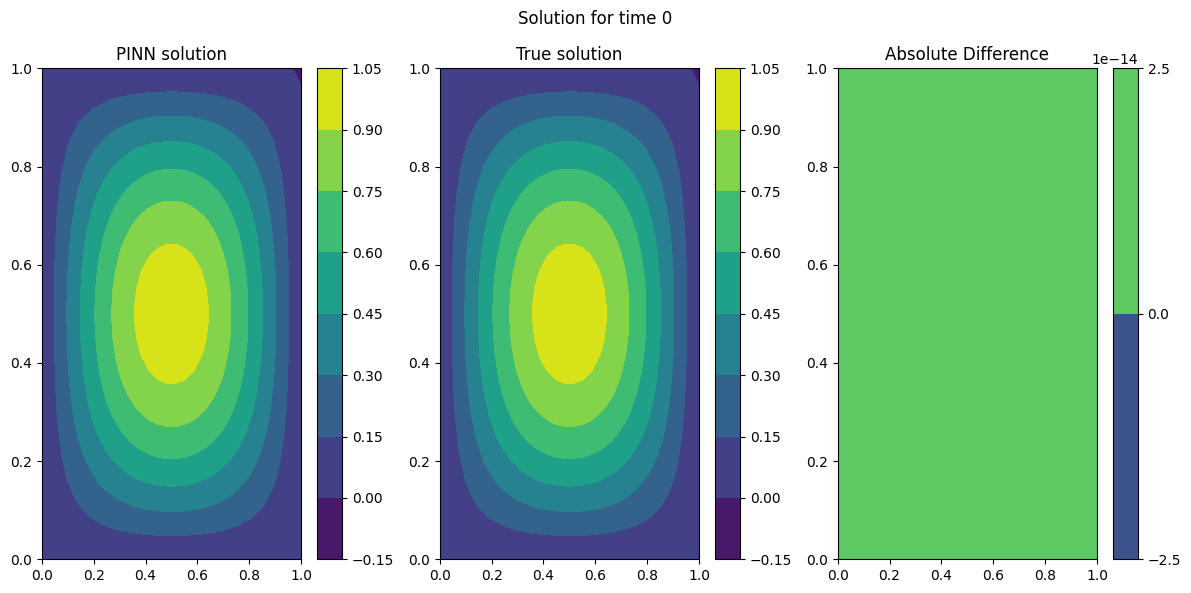

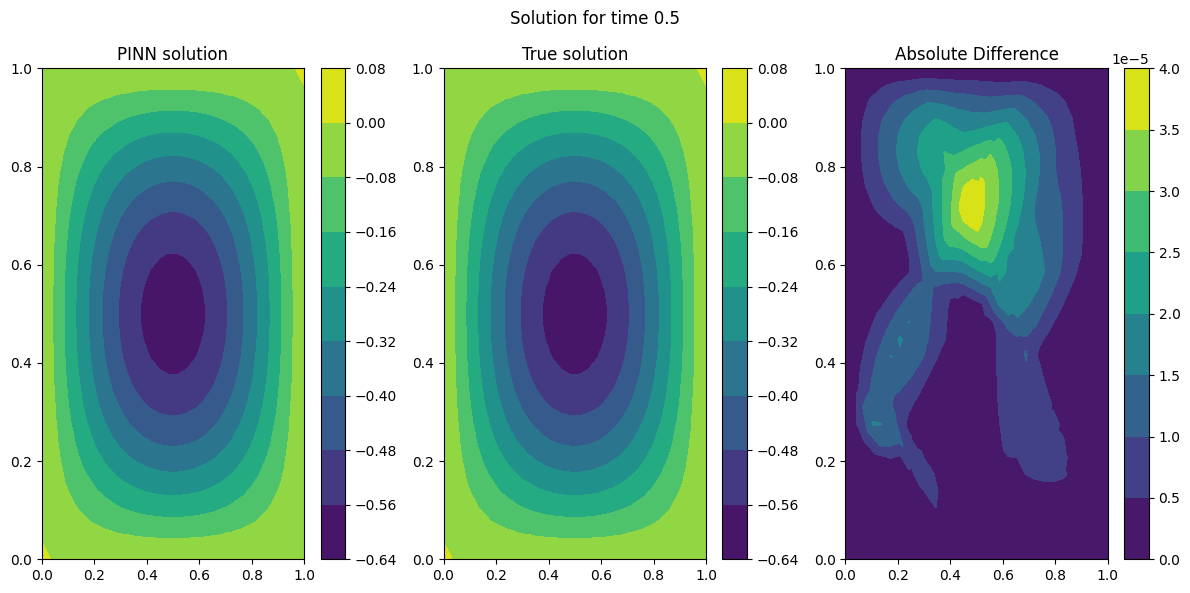

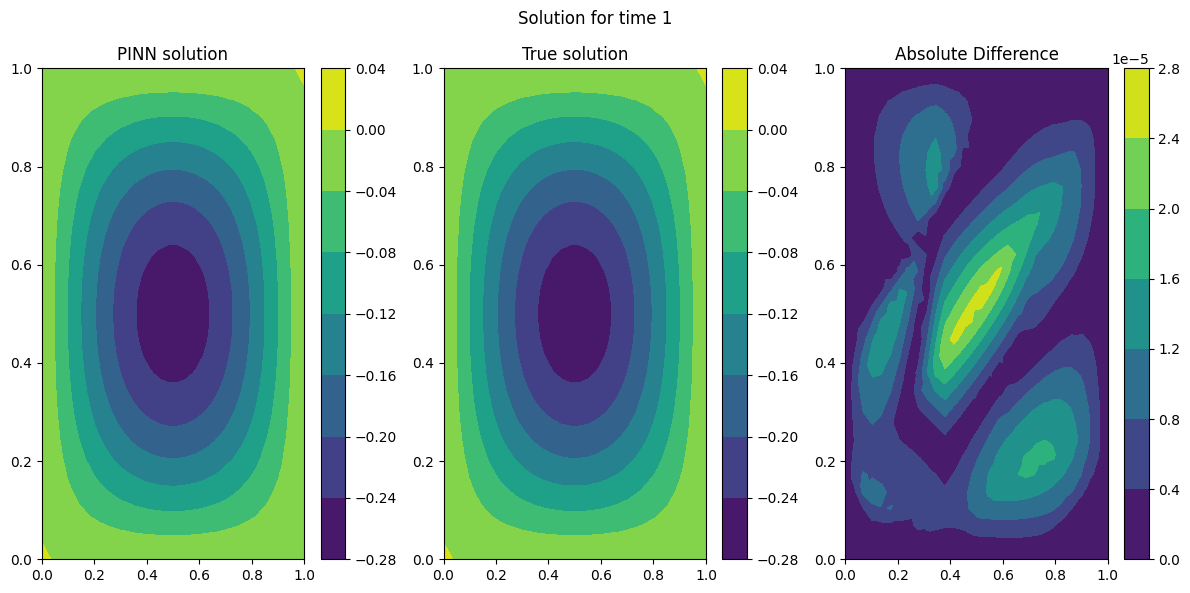

In [10]:
plt.figure(figsize=(12, 6))
plot_solution(solver=pinn, time=0)

plt.figure(figsize=(12, 6))
plot_solution(solver=pinn, time=0.5)

plt.figure(figsize=(12, 6))
plot_solution(solver=pinn, time=1)

We can see now that the results are way better! This is due to the fact that previously the network was  not learning correctly the initial conditon, leading to a poor solution when time evolved. By imposing the initial condition the network is able to correctly solve the problem. We can also see how the two losses decreased using Tensorboard.

In [ ]:
print("To visualize the loss you can run tensorboard --logdir 'tutorial_logs' on your terminal")

## What's next?

Congratulations on completing the two dimensional Wave tutorial of **PINA**! There are multiple directions you can go now:

1. Train the network for longer or with different layer sizes and assert the finaly accuracy

2. Propose new types of hard constraints in time, e.g. $$ u_{\rm{pinn}} = xy(1-x)(1-y)\cdot NN(x, y, t)(1-\exp(-t)) + \cos(\sqrt{2}\pi t)sin(\pi x)\sin(\pi y), $$

3. Exploit extrafeature training for model 1 and 2

4. Many more...